## **Import statements and set random seed**

In [1]:
# import time
import time
t1 = time.time()

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 88
tf_rand_seed = 33
np.random.seed(np_rand_seed)
# print("random seed of numpy: ", np_rand_seed)
# print("random seed of tensorflow: ", tf_rand_seed)

# **Loading training data**

In [4]:
train_data = pd.read_csv('../input/train.csv')

In [5]:
train_data.shape

(42000, 785)

In [6]:
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

In [8]:
features = train_data.columns.tolist()
output = "label"
features.remove(output)

In [9]:
train_X = train_data[features].as_matrix()
train_X = train_X.reshape((-1, n_steps, n_inputs))

In [10]:
train_y = train_data[output].as_matrix()
train_y = train_y.astype(int)
train_y = pd.get_dummies(train_y).as_matrix()

In [11]:
train_X.shape

(42000, 28, 28)

In [12]:
train_y.shape

(42000, 10)

# **Creating Convolutional Neural Network**

In [13]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
# sess = tf.InteractiveSession()

In [14]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [15]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]

In [16]:
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

In [17]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [18]:
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [19]:
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
logits

<tf.Tensor 'softmax/BiasAdd:0' shape=(?, 10) dtype=float32>

In [20]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

In [21]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

In [22]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)
y_true_cls = tf.argmax(y, axis=1, output_type=tf.int32)

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# **Train Model**

In [24]:
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))

image_train = train_X[train_indices]
image_validation = train_X[validation_indices]

labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

In [25]:
train_loss = []
valid_loss = []
valid_acc = []

train_batch_size = 250
max_iter = 1400

In [26]:
iteration = 0
best_accuracy = 0
best_iteration = 0
saver = tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    # while 59 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 58*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        rand_index_train = np.random.choice(labels_train.shape[0], size=train_batch_size)
        image_rand_train = image_train[rand_index_train]    
        labels_rand_train = labels_train[rand_index_train]

        feed_dict_batch =  {X: image_rand_train,
                            y: labels_rand_train}
        
#         feed_dict_train =  {X: image_rand_train,
#                             y: labels_rand_train}

        feed_dict_validation =  {X: image_validation,
                                 y: labels_validation}

        sess.run(train_step, feed_dict=feed_dict_batch)

        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_batch)
        train_loss.append(temp_train_loss)

        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)

        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)   
        
        # if valid accuracy is better than best recorded so far then update the best valid accuracy
        if temp_validation_accuracy > best_accuracy:
            best_accuracy = temp_validation_accuracy
            best_iteration = iteration
            saver.save(sess, './my-model', global_step = best_iteration)
            
        print("iterations:",iteration,
              ", train_loss:",temp_train_loss,
              ", valid_loss:", temp_validation_loss,
              ", valid_accuracy:", temp_validation_accuracy)
        
        iteration += 1

iterations: 0 , train_loss: 0.601074 , valid_loss: 0.605287 , valid_accuracy: 0.114762
iterations: 1 , train_loss: 0.515462 , valid_loss: 0.519208 , valid_accuracy: 0.107619
iterations: 2 , train_loss: 0.437455 , valid_loss: 0.437839 , valid_accuracy: 0.105238
iterations: 3 , train_loss: 0.378068 , valid_loss: 0.378385 , valid_accuracy: 0.105238
iterations: 4 , train_loss: 0.344771 , valid_loss: 0.343791 , valid_accuracy: 0.105238
iterations: 5 , train_loss: 0.32921 , valid_loss: 0.327291 , valid_accuracy: 0.105238
iterations: 6 , train_loss: 0.321671 , valid_loss: 0.322639 , valid_accuracy: 0.114762
iterations: 7 , train_loss: 0.323534 , valid_loss: 0.323373 , valid_accuracy: 0.204762
iterations: 8 , train_loss: 0.323966 , valid_loss: 0.32503 , valid_accuracy: 0.115238
iterations: 9 , train_loss: 0.319939 , valid_loss: 0.325328 , valid_accuracy: 0.115714
iterations: 10 , train_loss: 0.323256 , valid_loss: 0.32304 , valid_accuracy: 0.185238
iterations: 11 , train_loss: 0.318236 , valid

iterations: 94 , train_loss: 0.0531263 , valid_loss: 0.0638226 , valid_accuracy: 0.907143
iterations: 95 , train_loss: 0.0707625 , valid_loss: 0.0684561 , valid_accuracy: 0.892381
iterations: 96 , train_loss: 0.0503634 , valid_loss: 0.0621174 , valid_accuracy: 0.910952
iterations: 97 , train_loss: 0.0572543 , valid_loss: 0.0627433 , valid_accuracy: 0.90619
iterations: 98 , train_loss: 0.0666057 , valid_loss: 0.0625485 , valid_accuracy: 0.904762
iterations: 99 , train_loss: 0.0491487 , valid_loss: 0.0593314 , valid_accuracy: 0.918571
iterations: 100 , train_loss: 0.0507938 , valid_loss: 0.0571119 , valid_accuracy: 0.92
iterations: 101 , train_loss: 0.0631568 , valid_loss: 0.0604177 , valid_accuracy: 0.910952
iterations: 102 , train_loss: 0.0538725 , valid_loss: 0.0587666 , valid_accuracy: 0.917143
iterations: 103 , train_loss: 0.0512208 , valid_loss: 0.0556716 , valid_accuracy: 0.924286
iterations: 104 , train_loss: 0.0494506 , valid_loss: 0.0546912 , valid_accuracy: 0.927143
iterations

iterations: 185 , train_loss: 0.0259196 , valid_loss: 0.0345043 , valid_accuracy: 0.94619
iterations: 186 , train_loss: 0.0277308 , valid_loss: 0.0313569 , valid_accuracy: 0.955238
iterations: 187 , train_loss: 0.0317145 , valid_loss: 0.0316625 , valid_accuracy: 0.950952
iterations: 188 , train_loss: 0.0196156 , valid_loss: 0.036281 , valid_accuracy: 0.944762
iterations: 189 , train_loss: 0.0379328 , valid_loss: 0.038172 , valid_accuracy: 0.940952
iterations: 190 , train_loss: 0.0296424 , valid_loss: 0.0338171 , valid_accuracy: 0.949524
iterations: 191 , train_loss: 0.033559 , valid_loss: 0.0328207 , valid_accuracy: 0.950476
iterations: 192 , train_loss: 0.0267836 , valid_loss: 0.0340103 , valid_accuracy: 0.948571
iterations: 193 , train_loss: 0.025154 , valid_loss: 0.0337155 , valid_accuracy: 0.94619
iterations: 194 , train_loss: 0.022793 , valid_loss: 0.0338039 , valid_accuracy: 0.947143
iterations: 195 , train_loss: 0.0309162 , valid_loss: 0.0326006 , valid_accuracy: 0.950476
iterat

iterations: 276 , train_loss: 0.0210545 , valid_loss: 0.0276392 , valid_accuracy: 0.953809
iterations: 277 , train_loss: 0.0170902 , valid_loss: 0.0266052 , valid_accuracy: 0.958571
iterations: 278 , train_loss: 0.0207991 , valid_loss: 0.0264798 , valid_accuracy: 0.957619
iterations: 279 , train_loss: 0.0220854 , valid_loss: 0.0261794 , valid_accuracy: 0.959524
iterations: 280 , train_loss: 0.0106551 , valid_loss: 0.0265197 , valid_accuracy: 0.959048
iterations: 281 , train_loss: 0.0193473 , valid_loss: 0.0276254 , valid_accuracy: 0.958571
iterations: 282 , train_loss: 0.016041 , valid_loss: 0.0266595 , valid_accuracy: 0.960476
iterations: 283 , train_loss: 0.0195872 , valid_loss: 0.0264265 , valid_accuracy: 0.956667
iterations: 284 , train_loss: 0.0151224 , valid_loss: 0.0284744 , valid_accuracy: 0.955238
iterations: 285 , train_loss: 0.0279458 , valid_loss: 0.0297281 , valid_accuracy: 0.950952
iterations: 286 , train_loss: 0.0156318 , valid_loss: 0.0277167 , valid_accuracy: 0.955714


iterations: 367 , train_loss: 0.0180464 , valid_loss: 0.0226113 , valid_accuracy: 0.964286
iterations: 368 , train_loss: 0.0217524 , valid_loss: 0.022525 , valid_accuracy: 0.968095
iterations: 369 , train_loss: 0.0100841 , valid_loss: 0.0214224 , valid_accuracy: 0.969524
iterations: 370 , train_loss: 0.00957199 , valid_loss: 0.0202347 , valid_accuracy: 0.968095
iterations: 371 , train_loss: 0.0150773 , valid_loss: 0.0202491 , valid_accuracy: 0.964762
iterations: 372 , train_loss: 0.0122907 , valid_loss: 0.0211994 , valid_accuracy: 0.962381
iterations: 373 , train_loss: 0.0146968 , valid_loss: 0.0219359 , valid_accuracy: 0.96
iterations: 374 , train_loss: 0.0138264 , valid_loss: 0.0213729 , valid_accuracy: 0.962857
iterations: 375 , train_loss: 0.0161081 , valid_loss: 0.0214204 , valid_accuracy: 0.965238
iterations: 376 , train_loss: 0.0130224 , valid_loss: 0.0224016 , valid_accuracy: 0.966667
iterations: 377 , train_loss: 0.0171283 , valid_loss: 0.0235253 , valid_accuracy: 0.96381
iter

iterations: 458 , train_loss: 0.00648101 , valid_loss: 0.0200451 , valid_accuracy: 0.967143
iterations: 459 , train_loss: 0.0132116 , valid_loss: 0.0190358 , valid_accuracy: 0.970476
iterations: 460 , train_loss: 0.0149082 , valid_loss: 0.0189087 , valid_accuracy: 0.971429
iterations: 461 , train_loss: 0.0106192 , valid_loss: 0.019376 , valid_accuracy: 0.970476
iterations: 462 , train_loss: 0.0130973 , valid_loss: 0.0199551 , valid_accuracy: 0.970952
iterations: 463 , train_loss: 0.0188277 , valid_loss: 0.0203325 , valid_accuracy: 0.968095
iterations: 464 , train_loss: 0.0171967 , valid_loss: 0.020092 , valid_accuracy: 0.967619
iterations: 465 , train_loss: 0.0129691 , valid_loss: 0.0194026 , valid_accuracy: 0.970476
iterations: 466 , train_loss: 0.00978402 , valid_loss: 0.0195944 , valid_accuracy: 0.970952
iterations: 467 , train_loss: 0.0188502 , valid_loss: 0.0200407 , valid_accuracy: 0.969524
iterations: 468 , train_loss: 0.0159917 , valid_loss: 0.0202609 , valid_accuracy: 0.969524

iterations: 548 , train_loss: 0.0101375 , valid_loss: 0.0184308 , valid_accuracy: 0.970952
iterations: 549 , train_loss: 0.00656971 , valid_loss: 0.0183951 , valid_accuracy: 0.970952
iterations: 550 , train_loss: 0.0076619 , valid_loss: 0.0182723 , valid_accuracy: 0.970476
iterations: 551 , train_loss: 0.013607 , valid_loss: 0.0180677 , valid_accuracy: 0.971905
iterations: 552 , train_loss: 0.0159083 , valid_loss: 0.0179717 , valid_accuracy: 0.971905
iterations: 553 , train_loss: 0.0189328 , valid_loss: 0.0179456 , valid_accuracy: 0.971429
iterations: 554 , train_loss: 0.00953763 , valid_loss: 0.0182965 , valid_accuracy: 0.973333
iterations: 555 , train_loss: 0.0138234 , valid_loss: 0.0187692 , valid_accuracy: 0.972381
iterations: 556 , train_loss: 0.0144167 , valid_loss: 0.018665 , valid_accuracy: 0.971905
iterations: 557 , train_loss: 0.00684647 , valid_loss: 0.0183308 , valid_accuracy: 0.970952
iterations: 558 , train_loss: 0.0104894 , valid_loss: 0.0175538 , valid_accuracy: 0.97095

iterations: 638 , train_loss: 0.00768526 , valid_loss: 0.020766 , valid_accuracy: 0.969048
iterations: 639 , train_loss: 0.0102112 , valid_loss: 0.019437 , valid_accuracy: 0.969524
iterations: 640 , train_loss: 0.00467644 , valid_loss: 0.0184223 , valid_accuracy: 0.970476
iterations: 641 , train_loss: 0.00716123 , valid_loss: 0.0173058 , valid_accuracy: 0.969048
iterations: 642 , train_loss: 0.0143735 , valid_loss: 0.016869 , valid_accuracy: 0.968095
iterations: 643 , train_loss: 0.00517052 , valid_loss: 0.0175418 , valid_accuracy: 0.969048
iterations: 644 , train_loss: 0.00560919 , valid_loss: 0.0182598 , valid_accuracy: 0.970952
iterations: 645 , train_loss: 0.010021 , valid_loss: 0.0185369 , valid_accuracy: 0.969048
iterations: 646 , train_loss: 0.00849053 , valid_loss: 0.0183668 , valid_accuracy: 0.968571
iterations: 647 , train_loss: 0.0136165 , valid_loss: 0.0179037 , valid_accuracy: 0.970476
iterations: 648 , train_loss: 0.00799689 , valid_loss: 0.0170676 , valid_accuracy: 0.970

iterations: 728 , train_loss: 0.010976 , valid_loss: 0.0189202 , valid_accuracy: 0.968095
iterations: 729 , train_loss: 0.00877996 , valid_loss: 0.0194582 , valid_accuracy: 0.968095
iterations: 730 , train_loss: 0.0120895 , valid_loss: 0.0195707 , valid_accuracy: 0.968095
iterations: 731 , train_loss: 0.00559072 , valid_loss: 0.0191587 , valid_accuracy: 0.969048
iterations: 732 , train_loss: 0.0111669 , valid_loss: 0.01873 , valid_accuracy: 0.970952
iterations: 733 , train_loss: 0.00474514 , valid_loss: 0.0184027 , valid_accuracy: 0.971905
iterations: 734 , train_loss: 0.00792757 , valid_loss: 0.0176631 , valid_accuracy: 0.974286
iterations: 735 , train_loss: 0.0100323 , valid_loss: 0.0166274 , valid_accuracy: 0.97619
iterations: 736 , train_loss: 0.00983645 , valid_loss: 0.0168929 , valid_accuracy: 0.977143
iterations: 737 , train_loss: 0.00766423 , valid_loss: 0.0178275 , valid_accuracy: 0.97381
iterations: 738 , train_loss: 0.0083621 , valid_loss: 0.0171277 , valid_accuracy: 0.97476

iterations: 818 , train_loss: 0.0102289 , valid_loss: 0.0151119 , valid_accuracy: 0.978095
iterations: 819 , train_loss: 0.00734629 , valid_loss: 0.0151522 , valid_accuracy: 0.977619
iterations: 820 , train_loss: 0.00425274 , valid_loss: 0.0149523 , valid_accuracy: 0.978571
iterations: 821 , train_loss: 0.0089291 , valid_loss: 0.0147849 , valid_accuracy: 0.979524
iterations: 822 , train_loss: 0.0079399 , valid_loss: 0.014662 , valid_accuracy: 0.980952
iterations: 823 , train_loss: 0.00496653 , valid_loss: 0.0142438 , valid_accuracy: 0.980952
iterations: 824 , train_loss: 0.00629238 , valid_loss: 0.0142388 , valid_accuracy: 0.980476
iterations: 825 , train_loss: 0.0106083 , valid_loss: 0.0148481 , valid_accuracy: 0.974762
iterations: 826 , train_loss: 0.00829563 , valid_loss: 0.0154091 , valid_accuracy: 0.974762
iterations: 827 , train_loss: 0.0104058 , valid_loss: 0.015691 , valid_accuracy: 0.975714
iterations: 828 , train_loss: 0.00850345 , valid_loss: 0.0156088 , valid_accuracy: 0.97

iterations: 908 , train_loss: 0.00915796 , valid_loss: 0.0121449 , valid_accuracy: 0.980476
iterations: 909 , train_loss: 0.00527662 , valid_loss: 0.0125147 , valid_accuracy: 0.980476
iterations: 910 , train_loss: 0.00622991 , valid_loss: 0.0128532 , valid_accuracy: 0.979524
iterations: 911 , train_loss: 0.00501953 , valid_loss: 0.0136492 , valid_accuracy: 0.98
iterations: 912 , train_loss: 0.00470026 , valid_loss: 0.0139509 , valid_accuracy: 0.98
iterations: 913 , train_loss: 0.00811539 , valid_loss: 0.0133861 , valid_accuracy: 0.980952
iterations: 914 , train_loss: 0.00429851 , valid_loss: 0.0134025 , valid_accuracy: 0.981429
iterations: 915 , train_loss: 0.00350616 , valid_loss: 0.0134141 , valid_accuracy: 0.981429
iterations: 916 , train_loss: 0.00938189 , valid_loss: 0.0132776 , valid_accuracy: 0.980952
iterations: 917 , train_loss: 0.00409079 , valid_loss: 0.0135208 , valid_accuracy: 0.979524
iterations: 918 , train_loss: 0.00384302 , valid_loss: 0.0136835 , valid_accuracy: 0.979

iterations: 998 , train_loss: 0.00694436 , valid_loss: 0.0114242 , valid_accuracy: 0.982857
iterations: 999 , train_loss: 0.00655497 , valid_loss: 0.011433 , valid_accuracy: 0.983333
iterations: 1000 , train_loss: 0.00724345 , valid_loss: 0.0120587 , valid_accuracy: 0.98381
iterations: 1001 , train_loss: 0.0021719 , valid_loss: 0.013017 , valid_accuracy: 0.980952
iterations: 1002 , train_loss: 0.00689968 , valid_loss: 0.014045 , valid_accuracy: 0.977619
iterations: 1003 , train_loss: 0.0117001 , valid_loss: 0.0146295 , valid_accuracy: 0.975714
iterations: 1004 , train_loss: 0.00312567 , valid_loss: 0.0143519 , valid_accuracy: 0.978095
iterations: 1005 , train_loss: 0.00396809 , valid_loss: 0.0142039 , valid_accuracy: 0.979048
iterations: 1006 , train_loss: 0.00729883 , valid_loss: 0.0142147 , valid_accuracy: 0.978571
iterations: 1007 , train_loss: 0.00459352 , valid_loss: 0.014195 , valid_accuracy: 0.978095
iterations: 1008 , train_loss: 0.00289142 , valid_loss: 0.0144087 , valid_accur

In [27]:
print("Best accuracy is",best_accuracy,"attained at iteration", best_iteration)

Best accuracy is 0.986667 attained at iteration 924


In [28]:
del(train_data,train_X,train_y,image_train, image_validation, labels_train, labels_validation)

# **Create submission file**

In [29]:
test_data = pd.read_csv('../input/test.csv')
test_X = test_data[features].as_matrix()
test_X = test_X.reshape((-1, n_steps, n_inputs))
iD = test_data.index.tolist()
print(test_X.shape)
del(test_data)

(28000, 28, 28)


In [30]:
with tf.Session() as sess:    
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = test_X.shape[0]
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        start = (step*i)
        end = (step*(i+1)) 
    
        # feed dictionary for the fold
        feed_dict_test =  {X: test_X[start:end]}

        # evaluate predictions of the fold
        fold_preds = y_pred_cls.eval(session=sess, feed_dict = feed_dict_test)
        
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
        
        print("Finished computing prediction for fold", i)
        
    preds = preds.astype(np.int)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId": iD, "Label": preds})
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-924
Finished computing prediction for fold 0
Finished computing prediction for fold 1
Finished computing prediction for fold 2
Finished computing prediction for fold 3
Finished computing prediction for fold 4
Finished computing prediction for fold 5
Finished computing prediction for fold 6
Finished computing prediction for fold 7
Finished computing prediction for fold 8
Finished computing prediction for fold 9


# **Visualize Performance**

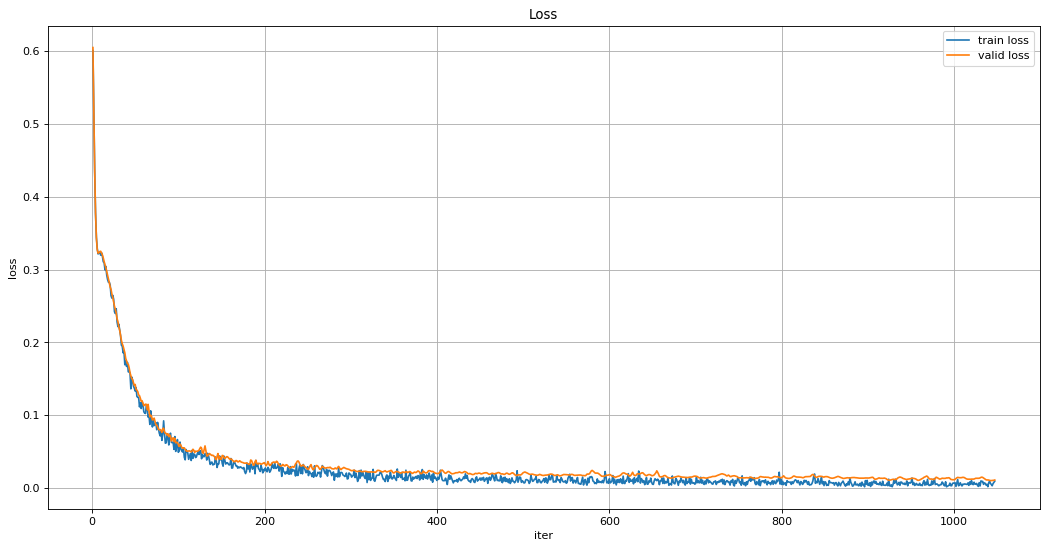

In [31]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

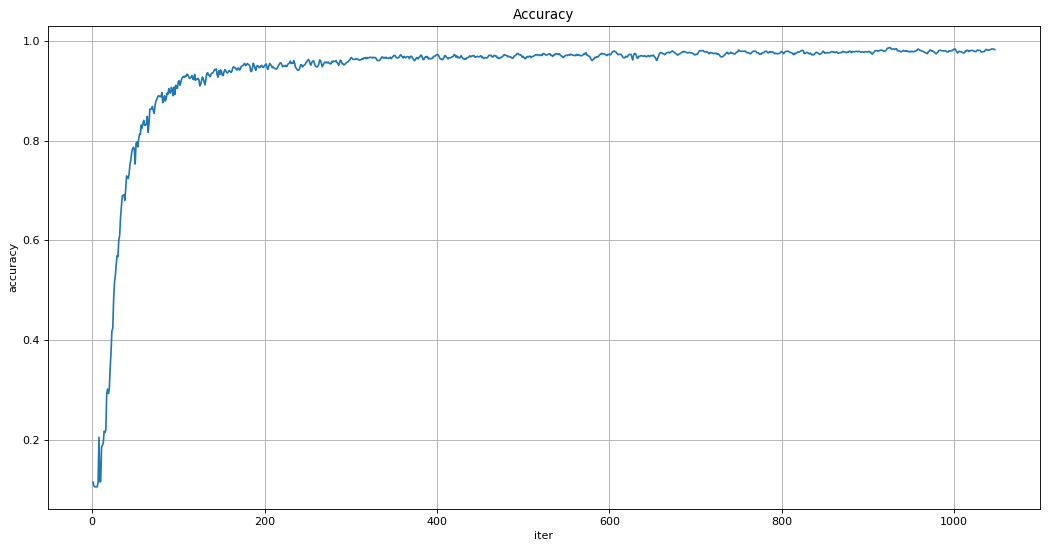

In [32]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()